In [1]:
%matplotlib inline

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import sys
import numpy
import random

from utils import *
from models import *

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [25]:
# Hyper Parameters
max_sequence_length = 50
max_vocabulary_size = 25000
embedding_size = 300 
hidden_size = 256
num_layers = 1
batch_size = 50
num_epochs = 50
learning_rate = 0.001
dropout_rate = 0
teacher_forcing_ratio = 0.5

#train_data_path = 'WD_0.10_aug_train_textbook.txt'
train_data_path = 'train_textbook_no_aug.txt'
valid_data_path = 'valid_textbook.txt'
test_data_path = 'inner_test.txt'
directory_name = 'att_tutorial_test'
encoder_name = 'ENC'
decoder_name = 'AttDEC'

word_to_ix, ix_to_word, vocab_size = make_or_load_dict(train_data_path, character=False)
#word_to_ix, ix_to_word, vocab_size = make_or_load_dict(train_data_path, character=True)
num_classes = vocab_size

2804


In [26]:
encoder = EncoderRNN(vocab_size, embedding_size, hidden_size, num_layers, 2, dropout_rate)
if decoder_name == 'AttDEC':
    decoder = AttnDecoderRNN(vocab_size, embedding_size, hidden_size, num_layers, num_classes, dropout_rate, max_sequence_length)
else:
    decoder = DecoderRNN(vocab_size, embedding_size, hidden_size, num_layers, num_classes, dropout_rate)

encoder = encoder.cuda()
decoder = decoder.cuda()
print(encoder)
print(decoder)

EncoderRNN(
  (dropout): Dropout(p=0)
  (word_embedding): Embedding(2804, 300)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=2)
)
AttnDecoderRNN(
  (dropout): Dropout(p=0)
  (W_A): Linear(in_features=812, out_features=50)
  (word_embedding): Embedding(2804, 300)
  (W_C): Linear(in_features=812, out_features=512)
  (lstm): LSTM(512, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=2804)
)


In [16]:
# BiLSTM load 되는지 테스트
model = BiLSTM(vocab_size, embedding_size, hidden_size, num_layers, 2, dropout_rate)
model.load_state_dict(torch.load('./models/'+directory_name+'/%s_hid%d_D%0.2f_tfr%0.1f_best_valid_accuracy.pkl' % (encoder_name, hidden_size, dropout_rate, teacher_forcing_ratio)))


In [31]:
encoder.load_state_dict(torch.load('./models/'+directory_name+'/%s_hid%d_D%0.2f_tfr%0.1f_best_valid_accuracy.pkl' % (encoder_name, hidden_size, dropout_rate, teacher_forcing_ratio)))
decoder.load_state_dict(torch.load('./models/'+directory_name+'/%s_hid%d_D%0.2f_tfr%0.1f_best_valid_accuracy.pkl' % (decoder_name, hidden_size, dropout_rate, teacher_forcing_ratio)))
#encoder.load_state_dict(torch.load('./models/'+directory_name+'/%s_hid%d_D%0.2f_tfr%0.1f.pkl' % (encoder_name, hidden_size, dropout_rate, teacher_forcing_ratio)))
#decoder.load_state_dict(torch.load('./models/'+directory_name+'/%s_hid%d_D%0.2f_tfr%0.1f.pkl' % (decoder_name, hidden_size, dropout_rate, teacher_forcing_ratio)))

In [17]:
def evaluate(encoder, decoder, input_variable):
    encoder_outputs, encoder_hidden = encoder(input_variable, train=False)
    
    SOS_token = 0
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda()
    decoder_hidden = encoder_hidden
    decoder_hidden = decoder.initHidden(1, encoder_hidden)

    decoded_words = []
    decoder_attentions = torch.zeros(max_sequence_length, max_sequence_length)

    stop_at_next_endofsentence = 0
    if decoder_name == 'AttDEC':
        for di in range(max_sequence_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs, train = False)
            decoder_attentions[di] = decoder_attention.view(-1, max_sequence_length).data

            # Choose top word from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            decoded_words.append(ni)
            if ni ==1: break

            # Next input is chosen word
            decoder_input = Variable(torch.LongTensor([[ni]])).cuda()
    else:
        for _ in range(max_sequence_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, train = False)

            # Choose top word from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            decoded_words.append(ni)
            if ni ==1: 
                if decoder_name == 'AE' and stop_at_next_endofsentence !=1:
                    stop_at_next_endofsentence = 1
                elif decoder_name == 'AE' and stop_at_next_endofsentence == 1:
                    break
                else:
                    break

            # Next input is chosen word
            decoder_input = Variable(torch.LongTensor([[ni]])).cuda()
        
    if decoder_name == 'AttDEC':
        return decoded_words, decoder_attentions[:di + 1]
    else:
        return decoded_words

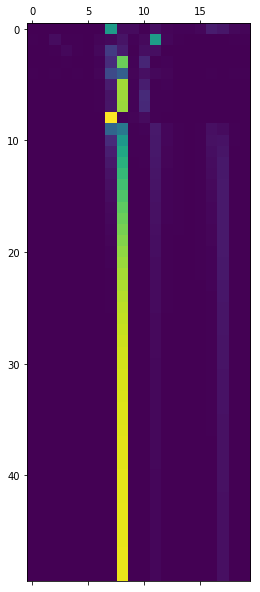

In [32]:
sentence = '¡ quítate de la puerta ! endofsentence'
sentence = sentence.split()
sentence_tensor = prepare_sequence(sentence, word_to_ix)
sentence = Variable(sentence_tensor.view(1, -1)).cuda()

output_words, attentions = evaluate(
    encoder, decoder, sentence)
#plt.matshow(attentions.numpy())
plt.matshow(attentions.numpy()[:, :20])

input = ¡ quítate de la puerta ! endofsentence
output = ¡ qué , ! , , , . unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk


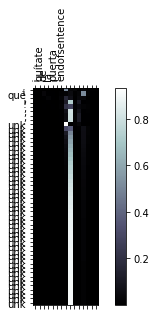

input = pero , ¿ no estabas pensando en buscar un trabajo ? endofsentence
output = no , no , no . . . unk . endofsentence


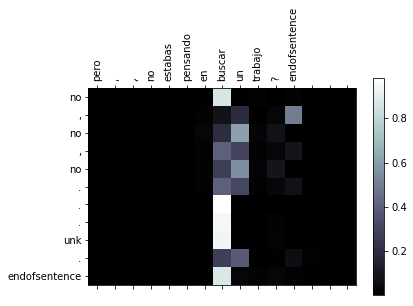

input = ¿ puedo dar el documento a la secretaria ? endofsentence
output = no , no . . endofsentence


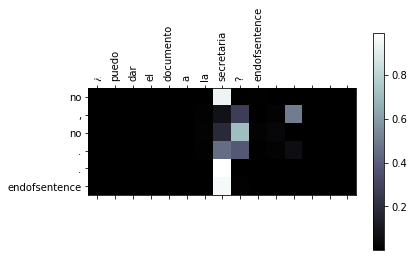

input = mucho gusto , quique . endofsentence
output = ¿ qué , ! , , , . unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk unk


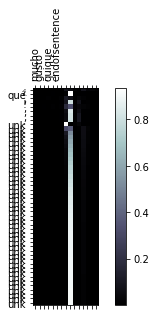

input = ¿ a qué hora salió el tren ayer ? endofsentence
output = no , no . . endofsentence


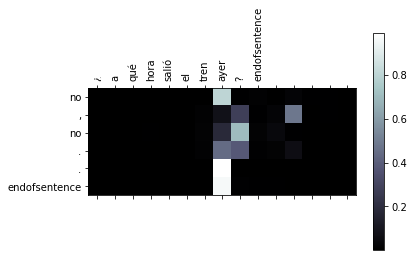

In [33]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    cax = ax.matshow(attentions.numpy()[:, :15], cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' '), rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder, decoder, sentence_to_input(input_sentence))
    print('input =', input_sentence)
    output_words = [ix_to_word[word_idx] for word_idx in output_words]
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


def sentence_to_input(sentence):
    sentence = sentence.split()
    sentence_tensor = prepare_sequence(sentence, word_to_ix)
    sentence = Variable(sentence_tensor.view(1, -1)).cuda()
    return sentence


evaluateAndShowAttention("¡ quítate de la puerta ! endofsentence")

evaluateAndShowAttention("pero , ¿ no estabas pensando en buscar un trabajo ? endofsentence")

evaluateAndShowAttention("¿ puedo dar el documento a la secretaria ? endofsentence")

evaluateAndShowAttention("mucho gusto , quique . endofsentence")

evaluateAndShowAttention("¿ a qué hora salió el tren ayer ? endofsentence")